In [1]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
from collections import OrderedDict
import sqlalchemy
import sys
import os
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

In [2]:
from data_access.load_file import load_table, dict_to_df
from data_processing.functions import time_for_phase, workitem_phases, set_end_date
from data_preparation import compute_work_item_times
from data_processing import features

First we want to load the data and compute the time of every resource

In [3]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)
total_times = compute_work_item_times(data)
times = time_for_phase(data, end_date="2018-03-31", process=False)
res_times = features.work_times(times.dropna(), phase_col="current_resource", time_col="duration_in_days", normalize=False)

In [5]:
open_wis = total_times[pd.isnull(total_times["duration_in_days"])]["work_item"].values
times_open = times[times.work_item.isin(open_wis)]
times_closed = times[~times.work_item.isin(open_wis)]
times_closed.dropna(inplace=True)

We already saw in notebook 4_resource_phase_eda that some of the resources are corresponding to the process phases. Which could be interesting too are the following things:

1. When does a resource recieves the work_item regarding to the timestamp?
2. How many work_items does the resource get at a period of time?
3. How many resources can work on one work item?
4. Which of the resources are more likely to work together?
5. How many resources are currently not working on a ticket?

We want to take a look on the first and second question. In first step we only want to look at the most frequent resources.

In [6]:
times_closed["current_resource"].value_counts().head(5)

ER_00239    2979
ER_00225    2530
ER_00149    2352
ER_00251    2198
ER_00061    2188
Name: current_resource, dtype: int64

This is a good example to check for because the resource works on all process phases. A truly generalist.

In [7]:
check_resources = times_closed["current_resource"].value_counts().head(5).index.values

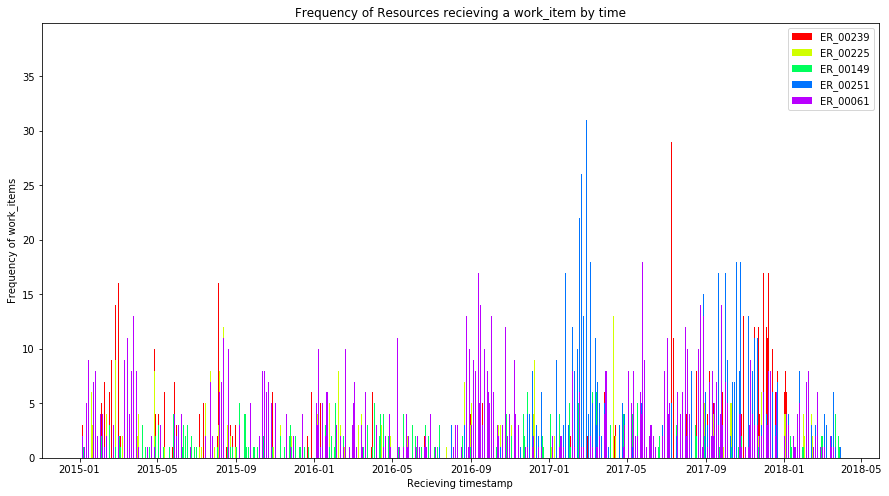

In [8]:
plt.figure(figsize=(15,8))
colors = plt.cm.get_cmap('hsv', len(check_resources)+1)
for re, i in zip(check_resources, range(len(check_resources))):
    er = times_closed[times_closed["current_resource"]==re]
    er.loc[:, "receive_date"] = er["from_timestamp"].apply(lambda x: x.date())
    er_date_freq = er.groupby("receive_date")["work_item"].nunique()
    plt.bar(x=er_date_freq.index, height=er_date_freq.values, color=colors(i), label=re)
plt.title("Frequency of Resources recieving a work_item by time")
plt.ylabel("Frequency of work_items")
plt.xlabel("Recieving timestamp")
plt.legend()
plt.show()

Besides the general beauty of the graph, we can see that some of the employees are more likely to work on multiple (up to 30!) work items at the same time. Could be because of problems that are similar or epmployees that have the skills to work on specific problems

Let's take a look at

3. How many resources can work on one work item?

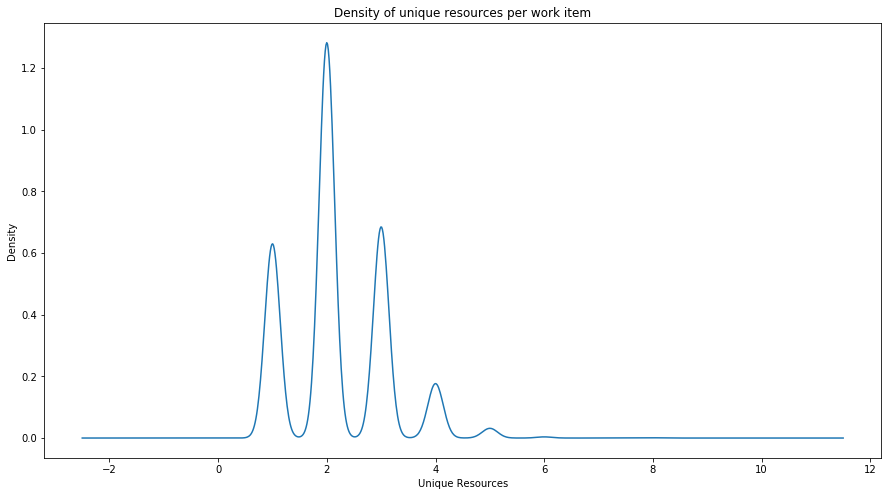

In [9]:
times_closed.groupby("work_item")["current_resource"].nunique().plot(kind="kde", figsize=(15,8))
plt.title("Density of unique resources per work item")
plt.xlabel("Unique Resources")
plt.show()

This density plot tells us the distribution of the unique resources. We can see that ~45% of work items are processed by 2 employees, while 20% is processed by 1 and another 20% is processed be 3 employees. This leads us directly to next question:

4. Which of the resources are more likely to work together?

In [10]:
def resource_prep(times, col, stop=0):
    processes = OrderedDict()
    for wi in times["work_item"].unique():
        vals = times[times["work_item"] == wi][col].unique()
        processes[wi] = vals
        if stop > 0:
            stop -= 1
            if stop == 0:
                break
    return processes

In [11]:
wi_res = resource_prep(times_closed.dropna(), col="current_resource")
res_df = dict_to_df(wi_res).T.rename(columns=dict(zip(range(8), [x+str(i) for x in ["resource_"]*8 for i in range(8)])))

In [12]:
res_df.head()

,resource_0,resource_1,resource_2,resource_3,resource_4,resource_5,resource_6,resource_7
WI_000001,ER_00043,ER_00149,ER_00058,NaN,NaN,NaN,NaN,NaN
WI_000002,ER_00225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WI_000003,ER_00225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WI_000004,ER_00225,ER_00239,ER_00061,NaN,NaN,NaN,NaN,NaN
WI_000005,ER_00206,ER_00075,ER_00088,NaN,NaN,NaN,NaN,NaN


Nice! Exactly what we want. Now we want to see the correlation between the resources

In [13]:
two_res = res_df[~pd.isnull(res_df["resource_1"])]
cross = pd.crosstab(two_res["resource_0"], two_res["resource_1"])
max_corr = pd.DataFrame(cross.idxmax(), columns=["resource_0"]).reset_index()[["resource_0", "resource_1"]]

In [14]:
for t in max_corr.iterrows():
    index = t[0]
    max_corr.loc[index, "abs_freq"] = cross.loc[max_corr.loc[index, "resource_0"], max_corr.loc[index, "resource_1"]]

In [15]:
max_corr.sort_values(by="abs_freq", ascending=False, inplace=True)

In [16]:
max_corr.head(10)

,resource_0,resource_1,abs_freq
138,ER_00206,ER_00287,417.0
113,ER_00061,ER_00225,336.0
37,ER_00273,ER_00073,209.0
118,ER_00061,ER_00239,174.0
46,ER_00048,ER_00091,138.0
39,ER_00206,ER_00075,131.0
103,ER_00174,ER_00212,106.0
107,ER_00061,ER_00217,94.0
140,ER_00061,ER_00291,92.0
34,ER_00253,ER_00068,84.0


As seen before in the most frequent processes the first two rows have the highest frequency. We also already know, that ER_00061 corresponds to the phase Analyze. So this employee could have a key role analyzing the work item first and then assigning it to an other employee for further processing.

5. How many resources are currently not working on a ticket?

In [17]:
times_closed.loc[:, "receive_date"] = times_closed["from_timestamp"].apply(lambda x: x.date())
times_closed.loc[:, "drop_date"] = times_closed["to_timestamp"].apply(lambda x: x.date())

In [18]:
daterange = pd.date_range(start=str(times_closed["receive_date"].min()), end=str(times_closed["drop_date"].max()), freq='D')

In [19]:
workload = pd.DataFrame(index=daterange, columns=["working_resources", "total_resources"])

In [20]:
for date in daterange:
    actual_working = times_closed[(times_closed["receive_date"] <= date.date()) & (times_closed["drop_date"] >= date.date())]
    workload.loc[date, "working_resources"] = actual_working["current_resource"].nunique()
    monthly_workers = times_closed[(times_closed["receive_date"].apply(lambda x: x.year) == date.year) & 
                                    (times_closed["receive_date"].apply(lambda x: x.month) <= date.month) &
                                    (times_closed["drop_date"].apply(lambda x: x.month) >= date.month)]
    workload.loc[date, "total_resources"] = monthly_workers["current_resource"].nunique()

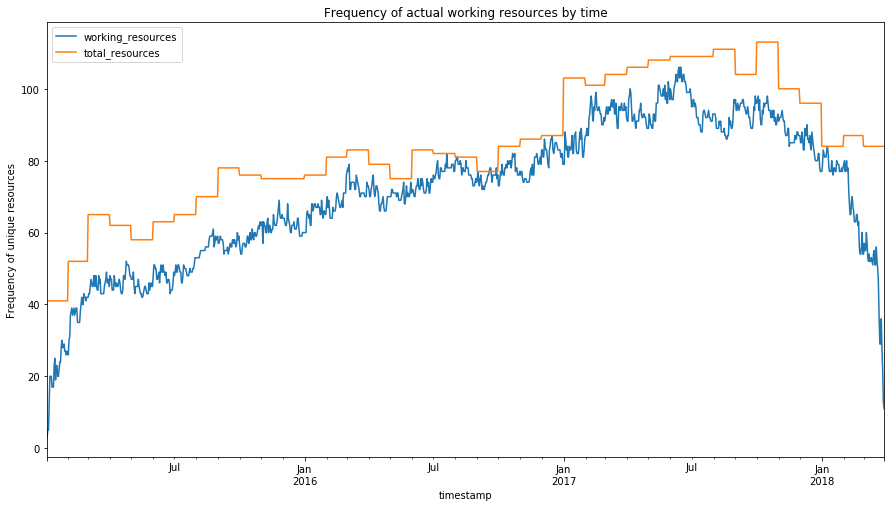

In [21]:
workload.plot(figsize=(15,8))
plt.title("Frequency of actual working resources by time")
plt.xlabel("timestamp")
plt.ylabel("Frequency of unique resources")
plt.show()

The blue line shows the employees currently working on an work item. The orange line shows the aviable employees within this month. It seems like the company is reacting quite well with their human resources on the increasing amount of work items.

Now it could be interesting too, to know when a resource is going to close many work items at the same time. For that we will pick the most frequent resource and see how their frequency of work items behaves regarding to the time

In [22]:
times.dropna().sort_values(by="process_index", ascending=False).drop_duplicates("work_item")["current_resource"].value_counts().head()

ER_00061    1131
ER_00206     566
ER_00068     350
ER_00156     348
ER_00219     315
Name: current_resource, dtype: int64

In [23]:
topres = times_closed[times_closed["current_resource"]=="ER_00061"]
itemfreq = pd.DataFrame(index=daterange, columns=["item_freq"])
for date in daterange:
    actual_working = topres[(topres["receive_date"] <= date.date()) & (topres["drop_date"] >= date.date())]
    itemfreq.loc[date, "item_freq"] = actual_working["work_item"].nunique()

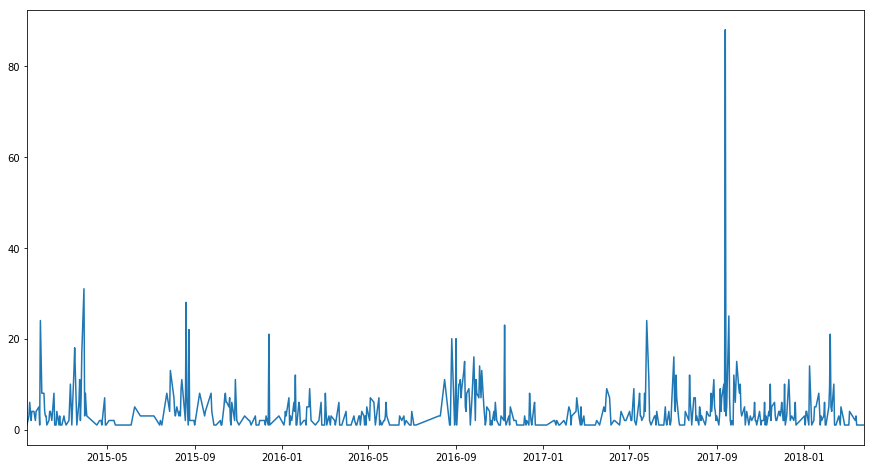

In [24]:
topres["drop_date"].value_counts().plot(figsize=(15,8))

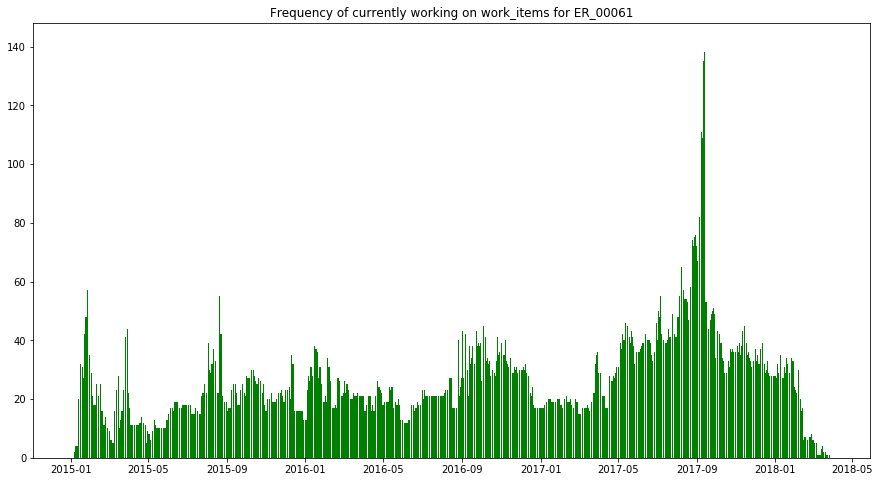

In [25]:
plt.figure(figsize=(15,8))
plt.bar(x=itemfreq.index, height=itemfreq.item_freq, color='g')
plt.title("Frequency of currently working on work_items for ER_00061")
plt.show()

In [26]:
tt = itemfreq.sort_values(by="item_freq", ascending=False).head()
tt.head()

,item_freq
2017-09-12,141
2017-09-13,138
2017-09-11,135
2017-09-08,111
2017-09-10,109


So on 2017-09-13 he closed many work_items which is impossibly on one day so if we could figure out why he did that and more important: When will he do this again?

In [27]:
closed_wis = topres[topres["drop_date"].apply(lambda x: x==tt.index[1].date())]["work_item"].unique()

In [28]:
data[data["work_item"].isin(closed_wis)].drop_duplicates("work_item")["domain"].value_counts()

BD_00002    88
Name: domain, dtype: int64

In [29]:
data[data["work_item"].isin(closed_wis)].drop_duplicates("work_item")["platform"].value_counts()

PL_00002    88
Name: platform, dtype: int64

In [30]:
data[data["work_item"].isin(closed_wis)].drop_duplicates("work_item")["components"].value_counts()

CO_00069                                        74
CO_00035                                         6
CO_00016/CO_00069                                5
CO_00035/CO_00069                                1
CO_00037/CO_00071                                1
CO_00060/CO_00053/CO_00122/CO_00010/CO_00069     1
Name: components, dtype: int64

That could be the depency. Seems like domain, platform and components are related to each other and used to group the work items. So the eployee picks up all tickets which are related to his platform and the components he might use for it. Then he can close all of the tickets at once.

We should definetly proof this!

What we also can use in our model: we get the work_item with it's platform and components and the resource who will work on it. The more work_items with the same platform and components he have the more urgent it is to solve the problem.

In [31]:
dmpl = data[data.work_item.isin(times_closed.work_item.unique())].drop_duplicates("work_item")
cross = pd.crosstab(dmpl["domain"], dmpl["platform"])
max_corr = pd.DataFrame(cross.idxmax(), columns=["domain"]).reset_index()[["domain", "platform"]]
for t in max_corr.iterrows():
    index = t[0]
    max_corr.loc[index, "abs_freq"] = cross.loc[max_corr.loc[index, "domain"], max_corr.loc[index, "platform"]]

In [32]:
max_corr.sort_values("abs_freq", ascending=False)

,domain,platform,abs_freq
1,BD_00002,PL_00002,2376.0
4,BD_00005,PL_00005,2017.0
0,BD_00001,PL_00001,827.0
11,BD_00007,PL_00012,747.0
2,BD_00003,PL_00003,739.0
7,BD_00003,PL_00008,582.0
15,BD_00010,PL_00016,523.0
5,BD_00006,PL_00006,478.0
8,BD_00008,PL_00009,377.0
18,BD_00009,PL_00019,362.0


Interesting! There is a mapping of domain and platform. Let's see the correlation to the time.

In [33]:
def domplat_workload(domain, platform):
    wis = data[(data["domain"]==domain) & (data["platform"]==platform)]["work_item"].unique()
    domplat = total_times[total_times["work_item"].isin(wis)]
    domplat.dropna(inplace=True)
    domplat.loc[:, "receive_date"] = domplat["start"].apply(lambda x: x.date())
    domplat.loc[:, "drop_date"] = domplat["end"].apply(lambda x: x.date())
    daterange = pd.date_range(start=str(domplat["receive_date"].min()), end=str(domplat["drop_date"].max()), freq='D')
    workload = pd.DataFrame(index=daterange, columns=["open_items"])
    for date in daterange:
        actual_working = domplat[(domplat["receive_date"] <= date.date()) & (domplat["drop_date"] >= date.date())]
        workload.loc[date, "open_items"] = actual_working["work_item"].nunique()
    return workload

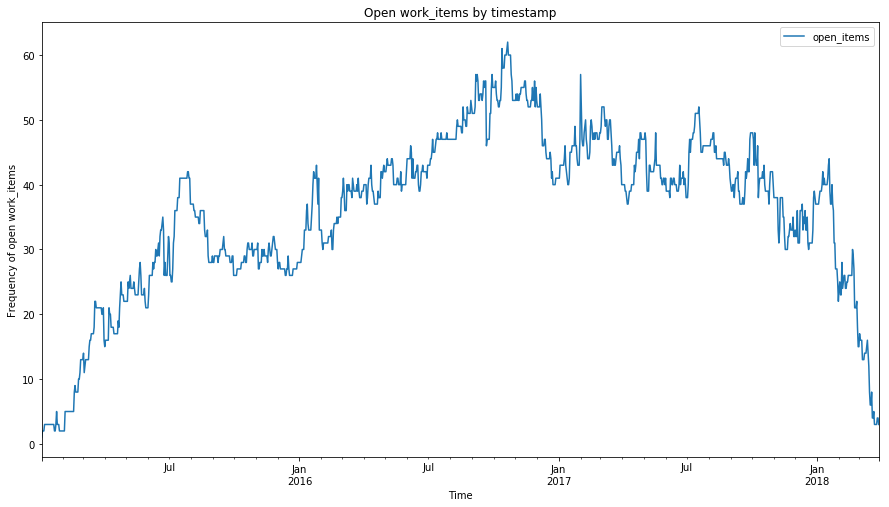

In [34]:
index = 0
domplat_workload(domain=max_corr.iloc[index]["domain"], platform=max_corr.iloc[index]["platform"]).plot(figsize=(15,8))
plt.title("Open work_items by timestamp")
plt.ylabel("Frequency of open work_items")
plt.xlabel("Time")
plt.show()

In [35]:
plcomp = data[data.work_item.isin(times_closed.work_item.unique())].drop_duplicates("work_item")
cross = pd.crosstab(plcomp["platform"], plcomp["components"])
max_corr = pd.DataFrame(cross.idxmax(), columns=["platform"]).reset_index()[["platform", "components"]]
for t in max_corr.iterrows():
    index = t[0]
    max_corr.loc[index, "abs_freq"] = cross.loc[max_corr.loc[index, "platform"], max_corr.loc[index, "components"]]

In [36]:
max_corr.sort_values("abs_freq", ascending=False).head()

,platform,components,abs_freq
240,PL_00002,CO_00153,725.0
177,PL_00003,CO_00113,633.0
47,PL_00002,CO_00035,488.0
185,PL_00008,CO_00118,486.0
170,PL_00005,CO_00108,331.0


Platform and components are correlated as well. It seems like there is a hirarchical order domain > platform > components. 
Let's see this in context of duration

In [37]:
def platcomp_workload(platform, components):
    wis = data[(data["platform"]==platform) & (data["components"]==components)]["work_item"].unique()
    platcomp = total_times[total_times["work_item"].isin(wis)]
    platcomp.dropna(inplace=True)
    platcomp.loc[:, "receive_date"] = platcomp["start"].apply(lambda x: x.date())
    platcomp.loc[:, "drop_date"] = platcomp["end"].apply(lambda x: x.date())
    daterange = pd.date_range(start=str(platcomp["receive_date"].min()), end=str(platcomp["drop_date"].max()), freq='D')
    workload = pd.DataFrame(index=daterange, columns=["open_items"])
    for date in daterange:
        actual_working = platcomp[(platcomp["receive_date"] <= date.date()) & (platcomp["drop_date"] >= date.date())]
        workload.loc[date, "open_items"] = actual_working["work_item"].nunique()
    return workload

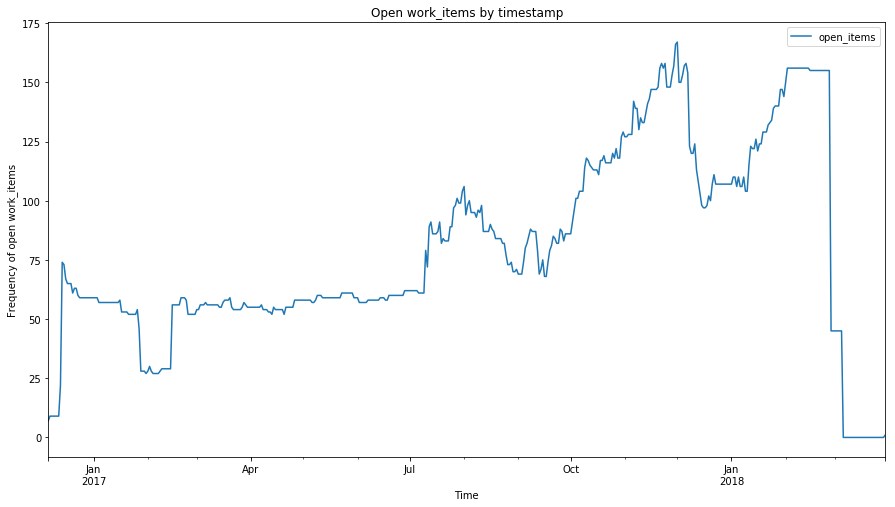

In [38]:
index = 240
platcomp_workload(platform=max_corr.iloc[index]["platform"], components=max_corr.iloc[index]["components"]).plot(figsize=(15,8))
plt.title("Open work_items by timestamp")
plt.ylabel("Frequency of open work_items")
plt.xlabel("Time")
plt.show()

This could be the next big improvement: cluster the work items by platform and components (which are belonging together) predict time for each cluster.

In [39]:
check_plat = "PL_00002"

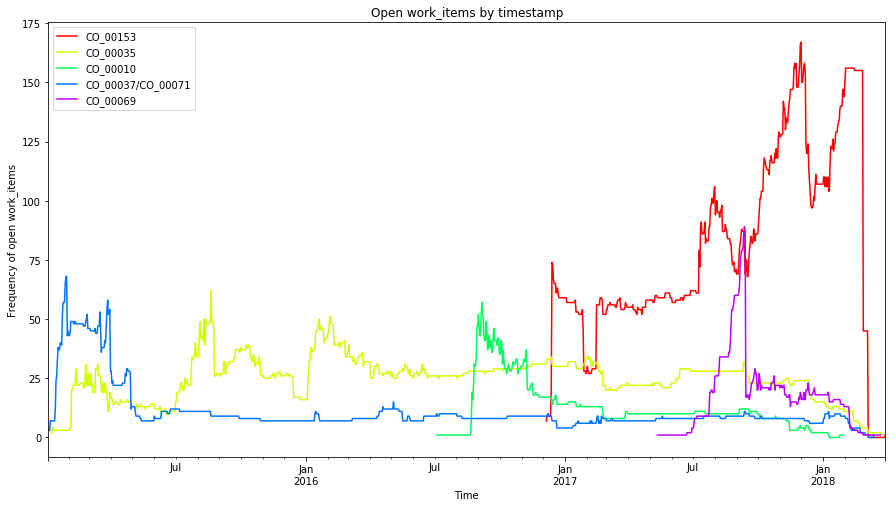

In [40]:
to_check = max_corr[max_corr["platform"]==check_plat].sort_values("abs_freq", ascending=False).head(5)
colors = plt.cm.get_cmap('hsv', len(to_check)+1)
ax = plt.subplot(111)
for index, i in zip(to_check.index, range(len(to_check))):
        wl = platcomp_workload(platform=max_corr.iloc[index]["platform"], components=max_corr.iloc[index]["components"])
        wl.rename(columns={"open_items":max_corr.iloc[index]["components"]}, inplace=True)
        wl.plot(figsize=(15,8), color=colors(i), ax=ax)
plt.title("Open work_items by timestamp")
plt.ylabel("Frequency of open work_items")
plt.xlabel("Time")
plt.legend()
plt.show()

We should try clustering to cluster domain, platform and components

In [41]:
def cluster_workload(clustered, cluster):
    wis = clustered[clustered["platcomp_cluster"] == cluster]["work_item"].unique()
    platcomp = total_times[total_times["work_item"].isin(wis)]
    platcomp.dropna(inplace=True)
    platcomp.loc[:, "receive_date"] = platcomp["start"].apply(lambda x: x.date())
    platcomp.loc[:, "drop_date"] = platcomp["end"].apply(lambda x: x.date())
    daterange = pd.date_range(start=str(platcomp["receive_date"].min()), end=str(platcomp["drop_date"].max()), freq='D')
    workload = pd.DataFrame(index=daterange, columns=["open_items"])
    for date in daterange:
        actual_working = platcomp[(platcomp["receive_date"] <= date.date()) & (platcomp["drop_date"] >= date.date())]
        workload.loc[date, "open_items"] = actual_working["work_item"].nunique()
    return workload

In [42]:
clustered = features.plat_comp_cluster(data, min_samples=90)

In [43]:
clusters = clustered.platcomp_cluster.nunique()
without = len(clustered[clustered.platcomp_cluster == -1])
print(f"We have {clusters} clusters, {len(clustered)} items and {without} items without a cluster")

We have 31 clusters, 11564 items and 2929 items without a cluster


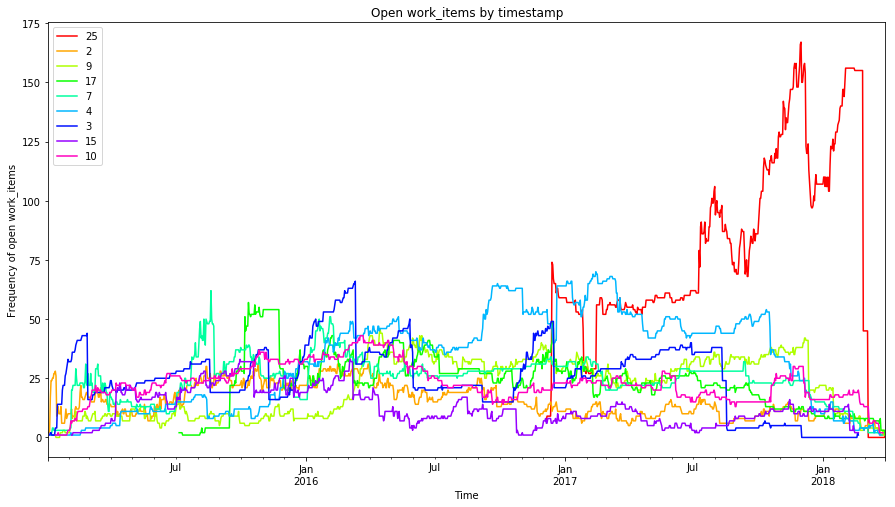

In [44]:
clusters = clustered.platcomp_cluster.value_counts()[1:10].index
colors = plt.cm.get_cmap('hsv', len(clusters)+1)
ax = plt.subplot(111)
for cluster, i in zip(clusters, range(len(clusters))):
        wl = cluster_workload(clustered, cluster)
        wl.rename(columns={"open_items":str(cluster)}, inplace=True)
        wl.plot(figsize=(15,8), color=colors(i), ax=ax)
plt.title("Open work_items by timestamp")
plt.ylabel("Frequency of open work_items")
plt.xlabel("Time")
plt.legend()
plt.show()

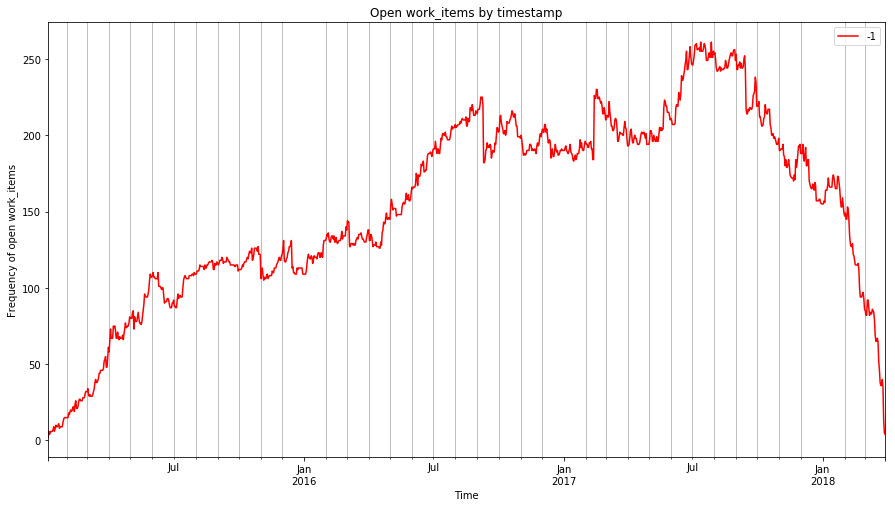

In [45]:
clusters = [-1]
colors = plt.cm.get_cmap('hsv', len(clusters)+1)
ax = plt.subplot(111)
for cluster, i in zip(clusters, range(len(clusters))):
        wl = cluster_workload(clustered, cluster)
        wl.rename(columns={"open_items":str(cluster)}, inplace=True)
        wl.plot(figsize=(15,8), color=colors(i), ax=ax)
plt.title("Open work_items by timestamp")
plt.ylabel("Frequency of open work_items")
plt.xlabel("Time")
plt.grid(which="minor")
plt.legend()
plt.show()

Seems like clusters have release cycles. Some items can not be closed until the end of one release cycle, so they might be more difficult than other ones. The idea:

1. Identify release days for each cluster
2. Set difficulty of a work item by init to 0
3. Anytime a work_item skips the realse day of it's cluster raise difficulty

Expected: Difficulty for long lasting work items increases with every release day

We define release days as the top 10 days regarding to the number of many work items that are closed

In [46]:
total_times = compute_work_item_times(data)

In [47]:
times_clustered = pd.merge(total_times, clustered).dropna()
times_clustered.loc[:, "receive_date"] = times_clustered["start"].apply(lambda x: x.date())
times_clustered.loc[:, "drop_date"] = times_clustered["end"].apply(lambda x: x.date())

In [48]:
releases = pd.DataFrame(times_clustered.groupby("platcomp_cluster").apply(lambda x: x["drop_date"].value_counts()))
releases.reset_index(inplace=True)
releases.rename(columns={"level_1":"release_date", "drop_date":"wi_count"}, inplace=True)

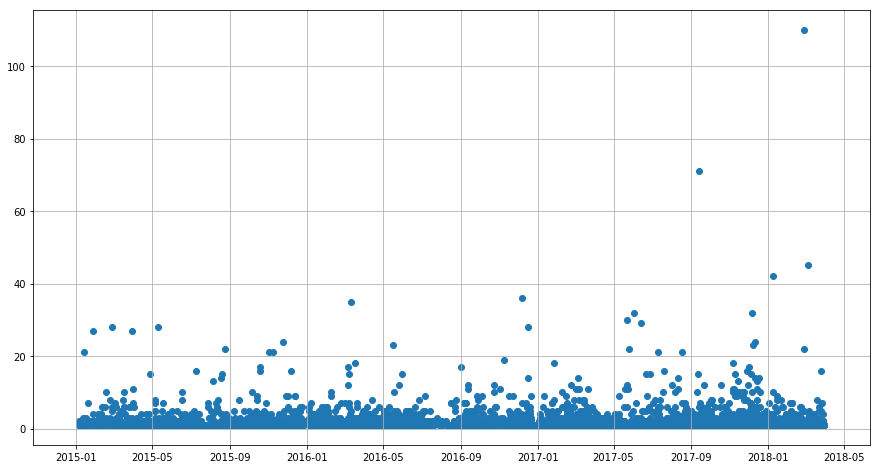

In [49]:
plot_df = releases[releases.platcomp_cluster!=-1]
plt.figure(figsize=(15,8))
plt.scatter(x=plot_df["release_date"], y=plot_df["wi_count"])
plt.grid(which="major")
plt.show()

In [50]:
release_days = pd.DataFrame(releases.groupby("platcomp_cluster")["release_date"].apply(lambda x: x.values)).reset_index()

In [51]:
total_times = compute_work_item_times(set_end_date(data, end_date="2018-03-31"))
times_clustered = pd.merge(total_times, clustered).dropna()
times_clustered.loc[:, "receive_date"] = times_clustered["start"].apply(lambda x: x.date())
times_clustered.loc[:, "drop_date"] = times_clustered["end"].apply(lambda x: x.date())

In [52]:
times_clustered =  pd.merge(times_clustered, release_days)

In [53]:
times_clustered.columns

Index(['work_item', 'start', 'end', 'duration', 'duration_in_days',
       'platcomp_cluster', 'receive_date', 'drop_date', 'release_date'],
      dtype='object')

In [54]:
times_clustered.loc[:, "difficulty"] = times_clustered.apply(lambda x: len([e for e in x["release_date"] if ((x["receive_date"]<e)&~(x["drop_date"]<=e))]), axis=1)

In [55]:
times_clustered.difficulty.value_counts().head()

0    3612
1    1126
2     791
3     671
4     515
Name: difficulty, dtype: int64

In [56]:
plot_open = times_clustered[times_clustered.work_item.isin(open_wis)]
plot_closed = times_clustered[~times_clustered.work_item.isin(open_wis)]

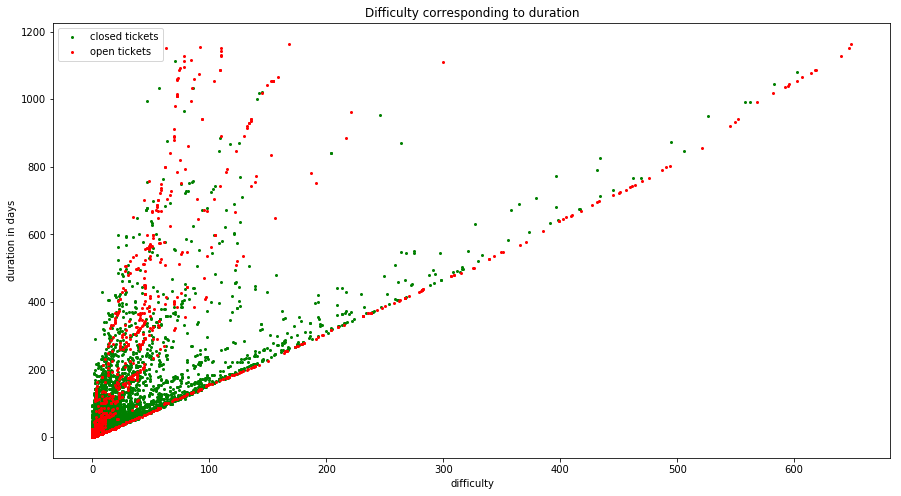

In [57]:
plt.figure(figsize=(15,8))
plt.scatter(x=plot_closed.difficulty, y=plot_closed.duration_in_days, s=4, color='g', label="closed tickets")
plt.scatter(x=plot_open.difficulty, y=plot_open.duration_in_days, s=4, color='r', label="open tickets")
plt.title("Difficulty corresponding to duration")
plt.xlabel("difficulty")
plt.ylabel("duration in days")
plt.legend()
plt.show()

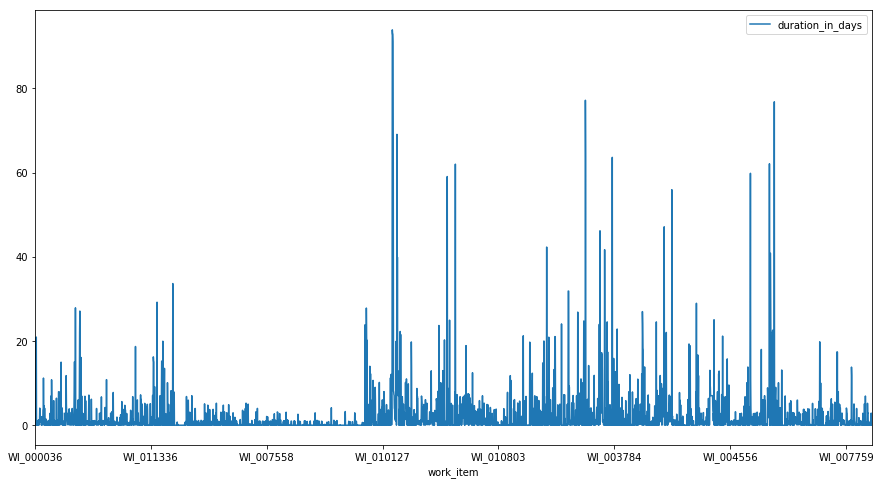

In [58]:
times_clustered[times_clustered.difficulty == 0][["work_item", "duration_in_days"]].set_index("work_item").plot(figsize=(15,8))